## Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter
from scipy.sparse import diags
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import os
from pyrocko import moment_tensor as pmt
path = "fgs/stf"
os.makedirs(path, exist_ok=True)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 18})
plt.rcParams['font.sans-serif']='Helvetica'
plt.rcParams['text.usetex'] = True #tex rendering

In [3]:
# Prepared on 20 05 2025 by Francesco De Rose, UniMuenster Geophysik
#
# NOTE: If you are more curious there are other notebooks you could examine.
# Please check the full repository: https://github.com/FrancescoDeRos/ionianbasin/
#
# Environment
# python virtual environment
# pip install matplotlib==3.8.0 seaborn==0.13.2 

## Input parameters

In [11]:
#read Par_file -----> Time step same as DT, Tot. # of steps same as NSTEP 
DT, NSTEP, EVENT, M0 = 5.999e-03, 5350 , "CatLido4.3",3.548136e15
print(f"DT: {DT:.5f}; ", f"NSTEP: {NSTEP:.0f}; ", f"Total time: {NSTEP*DT:.3f}", 's.')

DT: 0.00600;  NSTEP: 5350;  Total time: 32.095 s.


In [6]:
import numpy as np
#DECIDO IO
DT=0.0020
vmax=7999.9951
vmin=3370
#MESH
MIN=56.714
MAX=2481.445
AVG=MAX/4
T_MAX=(AVG/vmin) * 5
DT_SUGG=0.35*(MIN/vmax)
fmax=np.power(T_MAX,-1)
if DT < DT_SUGG:
    print(f"DT_SUGG:{DT_SUGG:.5f}, T_MAX:{T_MAX:.10f},fmax:{fmax:.5f},vp_max:{vmax:.5f},vs_min:{vmin:.5f}")
    print('Stable(?)')
else:
    print(f"DT_SUGG:{DT_SUGG:.5f}, T_MAX:{T_MAX:.10f},fmax:{fmax:.5f},vp_max:{vmax:.5f},vs_min:{vmin:.5f}")
    print('Unstable!')

DT_SUGG:0.00213, T_MAX:0.9204172849,fmax:1.08646,vp_max:7999.99510,vs_min:3370.00000
Stable(?)


## CMT conversion

The GCMT (Global Centroid Moment Tensor) convention components, as they are reported on the CMTSOLUTION file, are 
$M_{rr} , \, M_{tt} ,\, M_{pp} , \, M_{rt} , \, M_{rtp} , \, M_{tp} .$
These are in the Up South East (USE) coordinate system used by GCMT. To use them in Pyrocko (NED convention) a rotation must be performed.

In [ ]:
'''
CMTSOLUTION        PYROCKO         GCMT (USE)           NED
Mrr = U-U          mnn = N-N          U                 -D
Mtt = S-S          mee = E-E          S                 -N
Mpp = E-E          mdd = D-D          E                  E
Mrt = U-S          mne = N-E
Mrp = U-E          mnd = N-D
Mtp = S-E          med = E-D
'''

In [3]:
def read_mt_from_cmtsolution(filepath):
    moment = {}
    with open(filepath, 'r') as f:
        for line in f:
            if 'Mrr' in line:
                moment['Mrr'] = float(line.split()[-1])
            elif 'Mtt' in line:
                moment['Mtt'] = float(line.split()[-1])
            elif 'Mpp' in line:
                moment['Mpp'] = float(line.split()[-1])
            elif 'Mrt' in line:
                moment['Mrt'] = float(line.split()[-1])
            elif 'Mrp' in line:
                moment['Mrp'] = float(line.split()[-1])
            elif 'Mtp' in line:
                moment['Mtp'] = float(line.split()[-1])
    return moment
def find_cmtsolution_files(search_path):
    matches = []
    for root, dirs, files in os.walk(search_path):
        for filename in files:
            if "CMTSOLUTION" in filename:
                full_path = os.path.join(root, filename)
                print(f"[FOUND] {full_path}")
                matches.append(full_path)
    if not matches:
        print("[INFO] No CMTSOLUTION files found.")
    return matches

In [ ]:
#find CMTSOLUTION in the input directory for later postprocessing

In [12]:
cmts_files = find_cmtsolution_files(filepath)

[FOUND] /home/francesco/tesi/DATA/CMTSOLUTIONcatlido
[FOUND] /home/francesco/tesi/DATA/CMTSOLUTIONgreece29032024
[FOUND] /home/francesco/tesi/DATA/CMTSOLUTIONsicily
[FOUND] /home/francesco/tesi/DATA/CMTSOLUTION-southitaly5.1
[FOUND] /home/francesco/tesi/DATA/CMTSOLUTIONgreece


Insert in the next function what you got from your search in the directory. Otherwise copy in the current folder the CMTSOLUTION input file.

In [21]:
moment = read_mt_from_cmtsolution("/home/francesco/tesi/DATA/CMTSOLUTIONcatlido")
Mrr = moment['Mrr'];
Mtt = moment['Mtt'];
Mpp = moment['Mpp'];
Mrt = moment['Mrt'];
Mrp = moment['Mrp'];
Mtp = moment['Mtp'];
Minp=[Mrr,Mtt,Mpp,Mrt,Mrp,Mtp]
Minp = [np.format_float_scientific(val, precision=5, exp_digits=2, unique=False) for val in Minp]
print("INPUT:M_{rr} M_{tt}  M_{pp}  M_{rt}  M_{rtp}  M_{tp} :   ", Minp)
mnn =  Mtt         # N-N = S-S
mee =  Mpp         # E-E = E-E
mdd =  Mrr         # D-D = U-U
mne = -Mtp         # N-E = -S-E
mnd = -Mrt         # N-D = -U-S
med =  Mrp         # E-D = U-E
magnitude = 4.3  # Magnitude of the earthquake
print(f"$M_0$ =" ,"{:.5e}".format(pmt.magnitude_to_moment(magnitude)), "N . m")  # convert the mag to moment

INPUT:M_{rr} M_{tt}  M_{pp}  M_{rt}  M_{rtp}  M_{tp} :    ['8.44000e+14', '-8.02000e+14', '-4.20000e+13', '3.66000e+14', '3.41000e+14', '-2.68000e+14']
$M_0$ = 3.16228e+15 N . m


One should check between the value of the seismic moment $M_0$ and the average value of the moment tensor components to determine if they are expressed in dyne*cm or N * m
If not convert. In SPECFEM3D the components are in dyne * cm while in SPECFEM2D are in N * m (see manual.specfem2d pag26) 1 N.m = 1dyne.cm * 10^7  

In [23]:
M = np.array([mdd, mnn, mee, mnd, med, mne])#six MT components in the GCMT order
M = M * 1e7 # N*m into dyne*cm conversion
Mshort = [np.format_float_scientific(val, precision=5, exp_digits=2, unique=False) for val in M]
print(f"$M_{{rr}}$, $M_{{tt}}$, $M_{{pp}}$, $M_{{rt}}$, $M_{{rp}}$, $M_{{tp}}$ :", Mshort)#six components of MT in dyne . cm ready to be used in CMTSOLUTION

$M_{rr}$, $M_{tt}$, $M_{pp}$, $M_{rt}$, $M_{rp}$, $M_{tp}$ : ['8.44000e+21', '-8.02000e+21', '-4.20000e+20', '-3.66000e+21', '3.41000e+21', '2.68000e+21']


## Tomographic model dimensions

here one must specify the bounding boxes of its domain as well as the number of grid points in the tomographic model grid. The smaller the spacing the bigger the file size.
To give an estimate with NX=NY=22380 and Nz=33 one reaches an .xyz file of $\sim$ 500Gb. All the coordinates must match naturally with mesh model the user has created. If one works with UTM coordinates all these values are in meters.

In [25]:
xini,xend = 517071.945984 , 722459.802711 
yini,yend = 4094891.06208, 4430751.01969
zini, zend = -83000, 2229.74926758
Nx,Ny,Nz=100,180,171
ncellx=Nx-1; ncelly=Ny-1
ncellz=Nz-1;dx = (xend-xini)/ncellx
dy = (yend-yini)/ncelly ; dz = (zend-zini)/ncellz
print(f"dx: {dx:.2f}; ", f"dy: {dy:.2f}; ", f"dz: {dz:.2f}")

dx: 2074.62;  dy: 1876.31;  dz: 501.35


To performe the fft to get `X = fft(x)`, one would exploit the signal magnitude in the spectral domain: `A = |X| = sqrt(real(X)^2+ imag(X)^2)`. As for the imaginary part of the transform, it can be used to compute the signal phase: `Phi = Arg(X) = arctg(imag(X)/real(X))`. The Amplitude vs. Frequency spectrum is obtained by taking the absolute value of the fourier transform.
In the Brune function the relevant parameters will be in accordance to the one used by the Par_file and the solver xpecfem3D.

## STF plot

## ricker wavelet

In [ ]:
f0_r = .68  # target corner frequency ~1 Hz
EVENT = "ricker"
dt = 0.0025
NSTEP=31600
t = np.arange(0, NSTEP, dt)
# -------- Boxcar STF --------

rick_stf = np.zeros_like(t)

rick_stf = (1 - 2 * np.pi**2 * f0_r**2 * t**2) * np.exp(-np.pi**2 * f0_r**2  * t**2)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t, rick_stf, c='blue', label='Boxcar STF Mw < 4.0 ')
plt.plot(t, comp_source_time_function_brune, c='k', linestyle='--', label='Brune STF Mw ≥ 5.0')
plt.grid(True)
plt.xlim(-1.5,4.1)
plt.xlabel('Time (s)', fontsize=16, fontweight='bold')
plt.ylabel('Amplitude', fontsize=16, fontweight='bold')
plt.title('STFS ', fontsize=18, fontweight='bold')
plt.suptitle(r'Per tutte e due $f_0$ = {:.2f}; NSTEP = {:.0f}; DT = {:.4f}; EVENT = {}'.format(f0_brune, NSTEP, DT, EVENT),
             fontsize=20, fontweight='bold')
plt.legend(fontsize=14)
FFT_box = np.abs(dt * np.fft.fft(rick_stf))
FFT_brune = np.abs(dt * np.fft.fft(comp_source_time_function_brune))
n = len(FFT_box)
nf = int(np.ceil(n / 2))
df = 1.0 / (n * dt)
freq = np.arange(nf) * df
plt.subplot(1, 2, 2)
plt.loglog(freq, FFT_box[:nf], c='blue', label='|FFT(Ricker)|')
plt.loglog(freq, FFT_brune[:nf], c='k', linestyle='--', label='|FFT(Brune)|')
fc = f0_brune
brune_spectrum = FFT_brune[0] / (1.0 + (freq / fc) ** 2)
plt.loglog(freq, brune_spectrum, ls=':', color='red', label=r'Theoretical $\omega^{-2}$')
plt.grid(True, which='both')
plt.xlabel('Frequency (Hz)', fontsize=16, fontweight='bold')
plt.ylabel('Amplitude', fontsize=16, fontweight='bold')
plt.title('STF spectra', fontsize=18, fontweight='bold')
plt.legend(loc='lower left',fontsize=8)
#plt.savefig(os.path.join(path, f"ricker_f0{f0_b:.1f}_DT{DT:.4f}_NSTEP_{NSTEP}_EVENT_{EVENT}.png"),
 #           bbox_inches='tight', dpi=110)
plt.show()

## Save external STF to .txt file

Be sure to match the $DT$ value chosen in your simulation to the actual step of the external STF .txt file. The solver will trow an error saying it has red more lines than the NSTEP value but it's normal. As reported on the manual only one column file with amplitude data with each row related to each number of step of the simulation.

In [8]:
#Brune STF parameters: corner frequency in Hz , time vector , angular freq , stf values
f0 = f0_brune; t_brune = np.arange(0, dt * NSTEP, dt) ; brune_omega = 2 * np.pi * f0
brune_stf = brune_omega * brune_omega * t_brune * np.exp(-brune_omega* t_brune)
brune_stf /= np.trapz(brune_stf, t_brune) #unit area normalization
np.savetxt(path+"stf_brune.txt", brune_stf, fmt="%.17e")#one column, amplitude only, maximum double precision

In [7]:
#Boxcar STF parameters: corner frequency in Hz , time vector , angular freq , stf values
f0 = f0_b; t_box = np.arange(0, dt * NSTEP, dt) ; box_omega = 2 * np.pi * f0
boxcar_stf = np.zeros_like(t_box)
boxcar_duration = 1.0  # duration ~1/f0
cdt_box = (t_box >= 0.0) & (t_box <= boxcar_duration)
boxcar_stf[cdt_box] = 1.0
boxcar_stf /= np.trapz(boxcar_stf, t_box)# Normalize area to 1
np.savetxt(path+"stf_box.txt", boxcar_stf, fmt="%.17e")#one column, amplitude only, maximum double precision

In [8]:
# Boxcar STF parameters: corner frequency in Hz, time vector, angular freq, STF values
f0 = f0_b
t_box = np.arange(0, dt * NSTEP, dt)
box_omega = 2 * np.pi * f0
boxcar_stf = np.zeros_like(t_box)
boxcar_duration = 1.0  # duration ~1/f0
# Start Boxcar at 1.0s, end at 2.0s
boxcar_start = 1.0
boxcar_end = boxcar_start + boxcar_duration
cdt_box = (t_box >= boxcar_start) & (t_box <= boxcar_end)
boxcar_stf[cdt_box] = 1.0
boxcar_stf /= np.trapz(boxcar_stf, t_box)
np.savetxt(path + "stf_box.txt", boxcar_stf, fmt="%.17e")

In [33]:
#Trapez STF
f0 = fc_t; t_box = np.arange(0, dt * NSTEP, dt) ; box_omega = 2 * np.pi * f0
t = np.arange(0, dt * NSTEP, dt)  # 2x total duration for visualization
trapez_stf = trapezoidal_stf(t, tau_rise, tau_flat, tau_fall)
trapez_stf_moment_rate = trapez_stf * (Mo / (tau_rise + tau_flat + tau_fall))
np.savetxt(path+"stf_trapez.txt", trapez_stf_moment_rate, fmt="%.17e")#one column, amplitude only, maximum double precision

# STF

In [42]:
#read Par_file -----> Time step same as DT, Tot. # of steps same as NSTEP 
DT, NSTEP = 0.0020 , 120000
print(f"DT: {DT:.5f}; ", f"NSTEP: {NSTEP:.0f}; ", f"Total time: {NSTEP*DT:.3f}", 's.')
EVENT="20181025225451.5GREECE"

DT: 0.00200;  NSTEP: 120000;  Total time: 240.000 s.


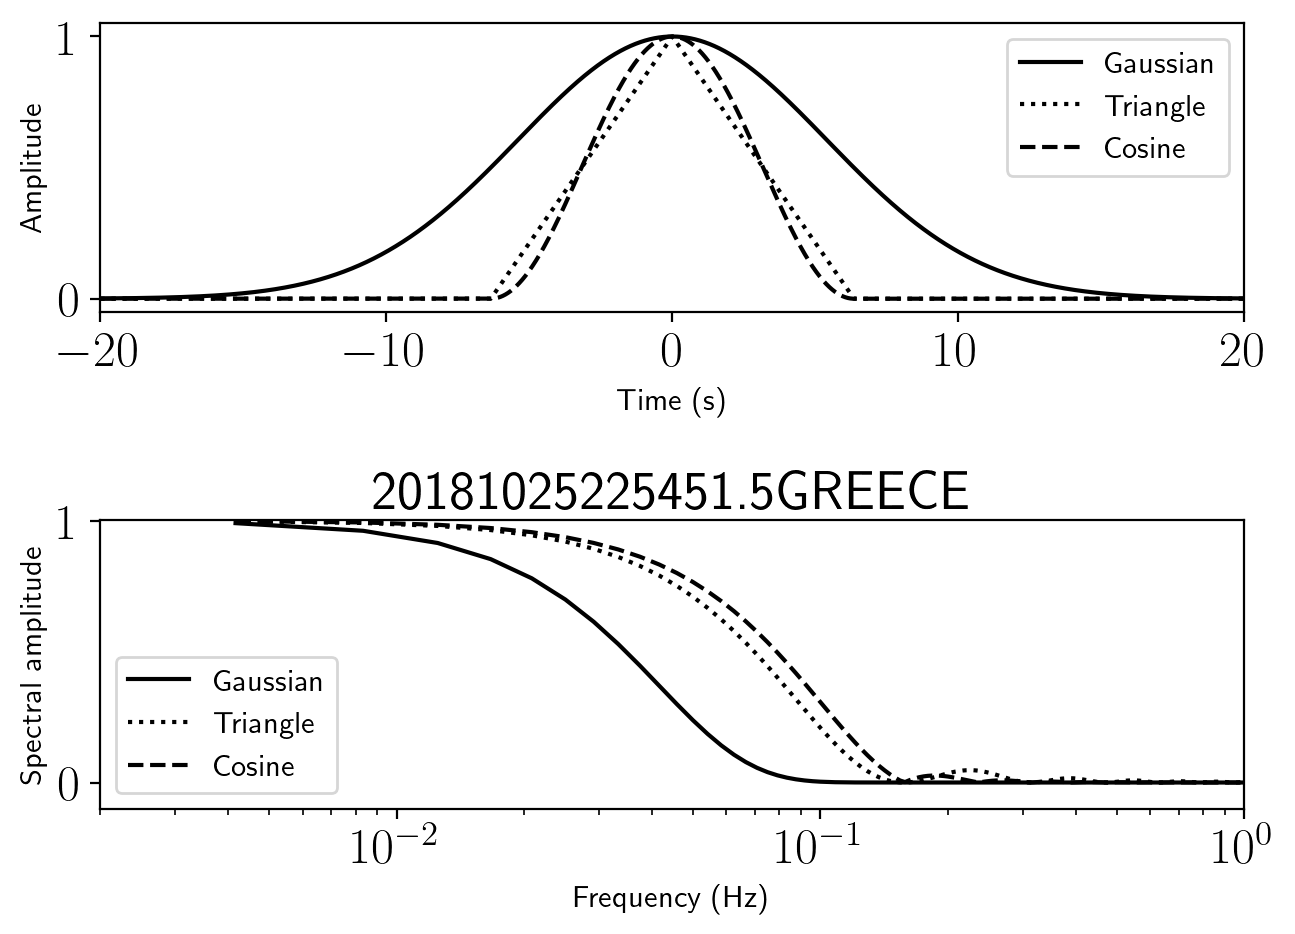

In [48]:
from matplotlib import rcParams
rcParams['axes.titlepad'] = 0.5
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, fftshift
from matplotlib.ticker import FormatStrFormatter
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 18})
plt.rcParams['text.usetex'] = True #tex rendering
TIME=220
TIME1=-20
t = np.arange(TIME1, TIME, DT)
n = len(t)
#BOXCAR
boxcar_start = 1.0
boxcar_duration = 1.0
boxcar_end = boxcar_start + boxcar_duration
cdt_box = (t >= boxcar_start) & (t <= boxcar_end)
boxcar_stf = np.zeros_like(t)
boxcar_stf[cdt_box] = 1.0
# Triangle STF (symmetric, peak at t=0, half-duration 18 s)
hdur = 6.35  # half duration
triangle = np.maximum(0, 1 - np.abs(t) / hdur)
triangle /= np.max(triangle)  # normalize
# Gaussian STF (standard deviation chosen to visually match the triangle's width)
std_dev = hdur / np.sqrt(2 * np.log(2))  # FWHM to std
gaussian = np.exp(-0.5 * (t / std_dev) ** 2)
gaussian /= np.max(gaussian)  # normalize
#cosine stf
T = 2 * hdur  #durata della cosine:proakis1986
pad = 2.0     #durata zeri prima e dop
n_total = int(T / DT)
n_pad = int(pad / DT)
n_main = n_total - 2 * n_pad
t = np.arange(TIME1, TIME, DT)
cosine = np.zeros_like(t)
mask = (t >= -hdur) & (t <= hdur)
cosine[mask] = 0.5 * (1 - np.cos(2 * np.pi * (t[mask] + hdur) / T))
#ffts
freq = fftshift(fftfreq(n, d=DT))
triangle_fft = np.abs(fftshift(fft(triangle)))
gaussian_fft = np.abs(fftshift(fft(gaussian)))
triangle_fft /= np.max(triangle_fft)
gaussian_fft /= np.max(gaussian_fft)
cosine_fft = np.abs(fftshift(fft(cosine)))
cosine_fft /= np.max(cosine_fft)
box_fft = np.abs(fftshift(fft(boxcar_stf)))
box_fft /= np.max(box_fft)         
plt.figure(figsize=(7, 5))
plt.subplot(2, 1, 1)
plt.plot(t, gaussian, c='black', label="Gaussian", linestyle='solid')
plt.plot(t, triangle, c='black', label="Triangle",linestyle='dotted')
plt.plot(t, cosine, c='black', label='Cosine',linestyle='dashed')
#plt.plot(t, boxcar_stf, c='blue', label='Boxcar')
plt.xlabel("Time (s)", fontsize=11, fontweight='bold')
plt.ylabel("Amplitude", fontsize=11, fontweight='bold')
plt.xlim(-20,20)
plt.legend(fontsize=11)
plt.subplot(2, 1, 2)
plt.semilogx(freq[freq > 0], gaussian_fft[freq > 0], c='black', label="Gaussian", linestyle='solid')
plt.semilogx(freq[freq > 0], triangle_fft[freq > 0],c='black', label="Triangle", linestyle='dotted')
plt.semilogx(freq[freq > 0], cosine_fft[freq > 0], c='black',label="Cosine", linestyle='dashed')
#plt.semilogx(freq[freq > 0], box_fft[freq > 0], label="boxcar", c='b')
ax= plt.gca()
plt.xlabel("Frequency (Hz)", fontsize=11, fontweight='bold')
plt.ylabel("Spectral amplitude", fontsize=11, fontweight='bold')
plt.title(r'{}'.format(EVENT),fontsize=20, fontweight='bold')
plt.legend(loc='lower left', fontsize=11)
plt.ylim(-0.1, 1.001)
plt.xlim(0.002, 1.0)
plt.tight_layout()
plt.savefig(f'stfs_{EVENT}.pdf',dpi=100, transparent=True)
plt.show()

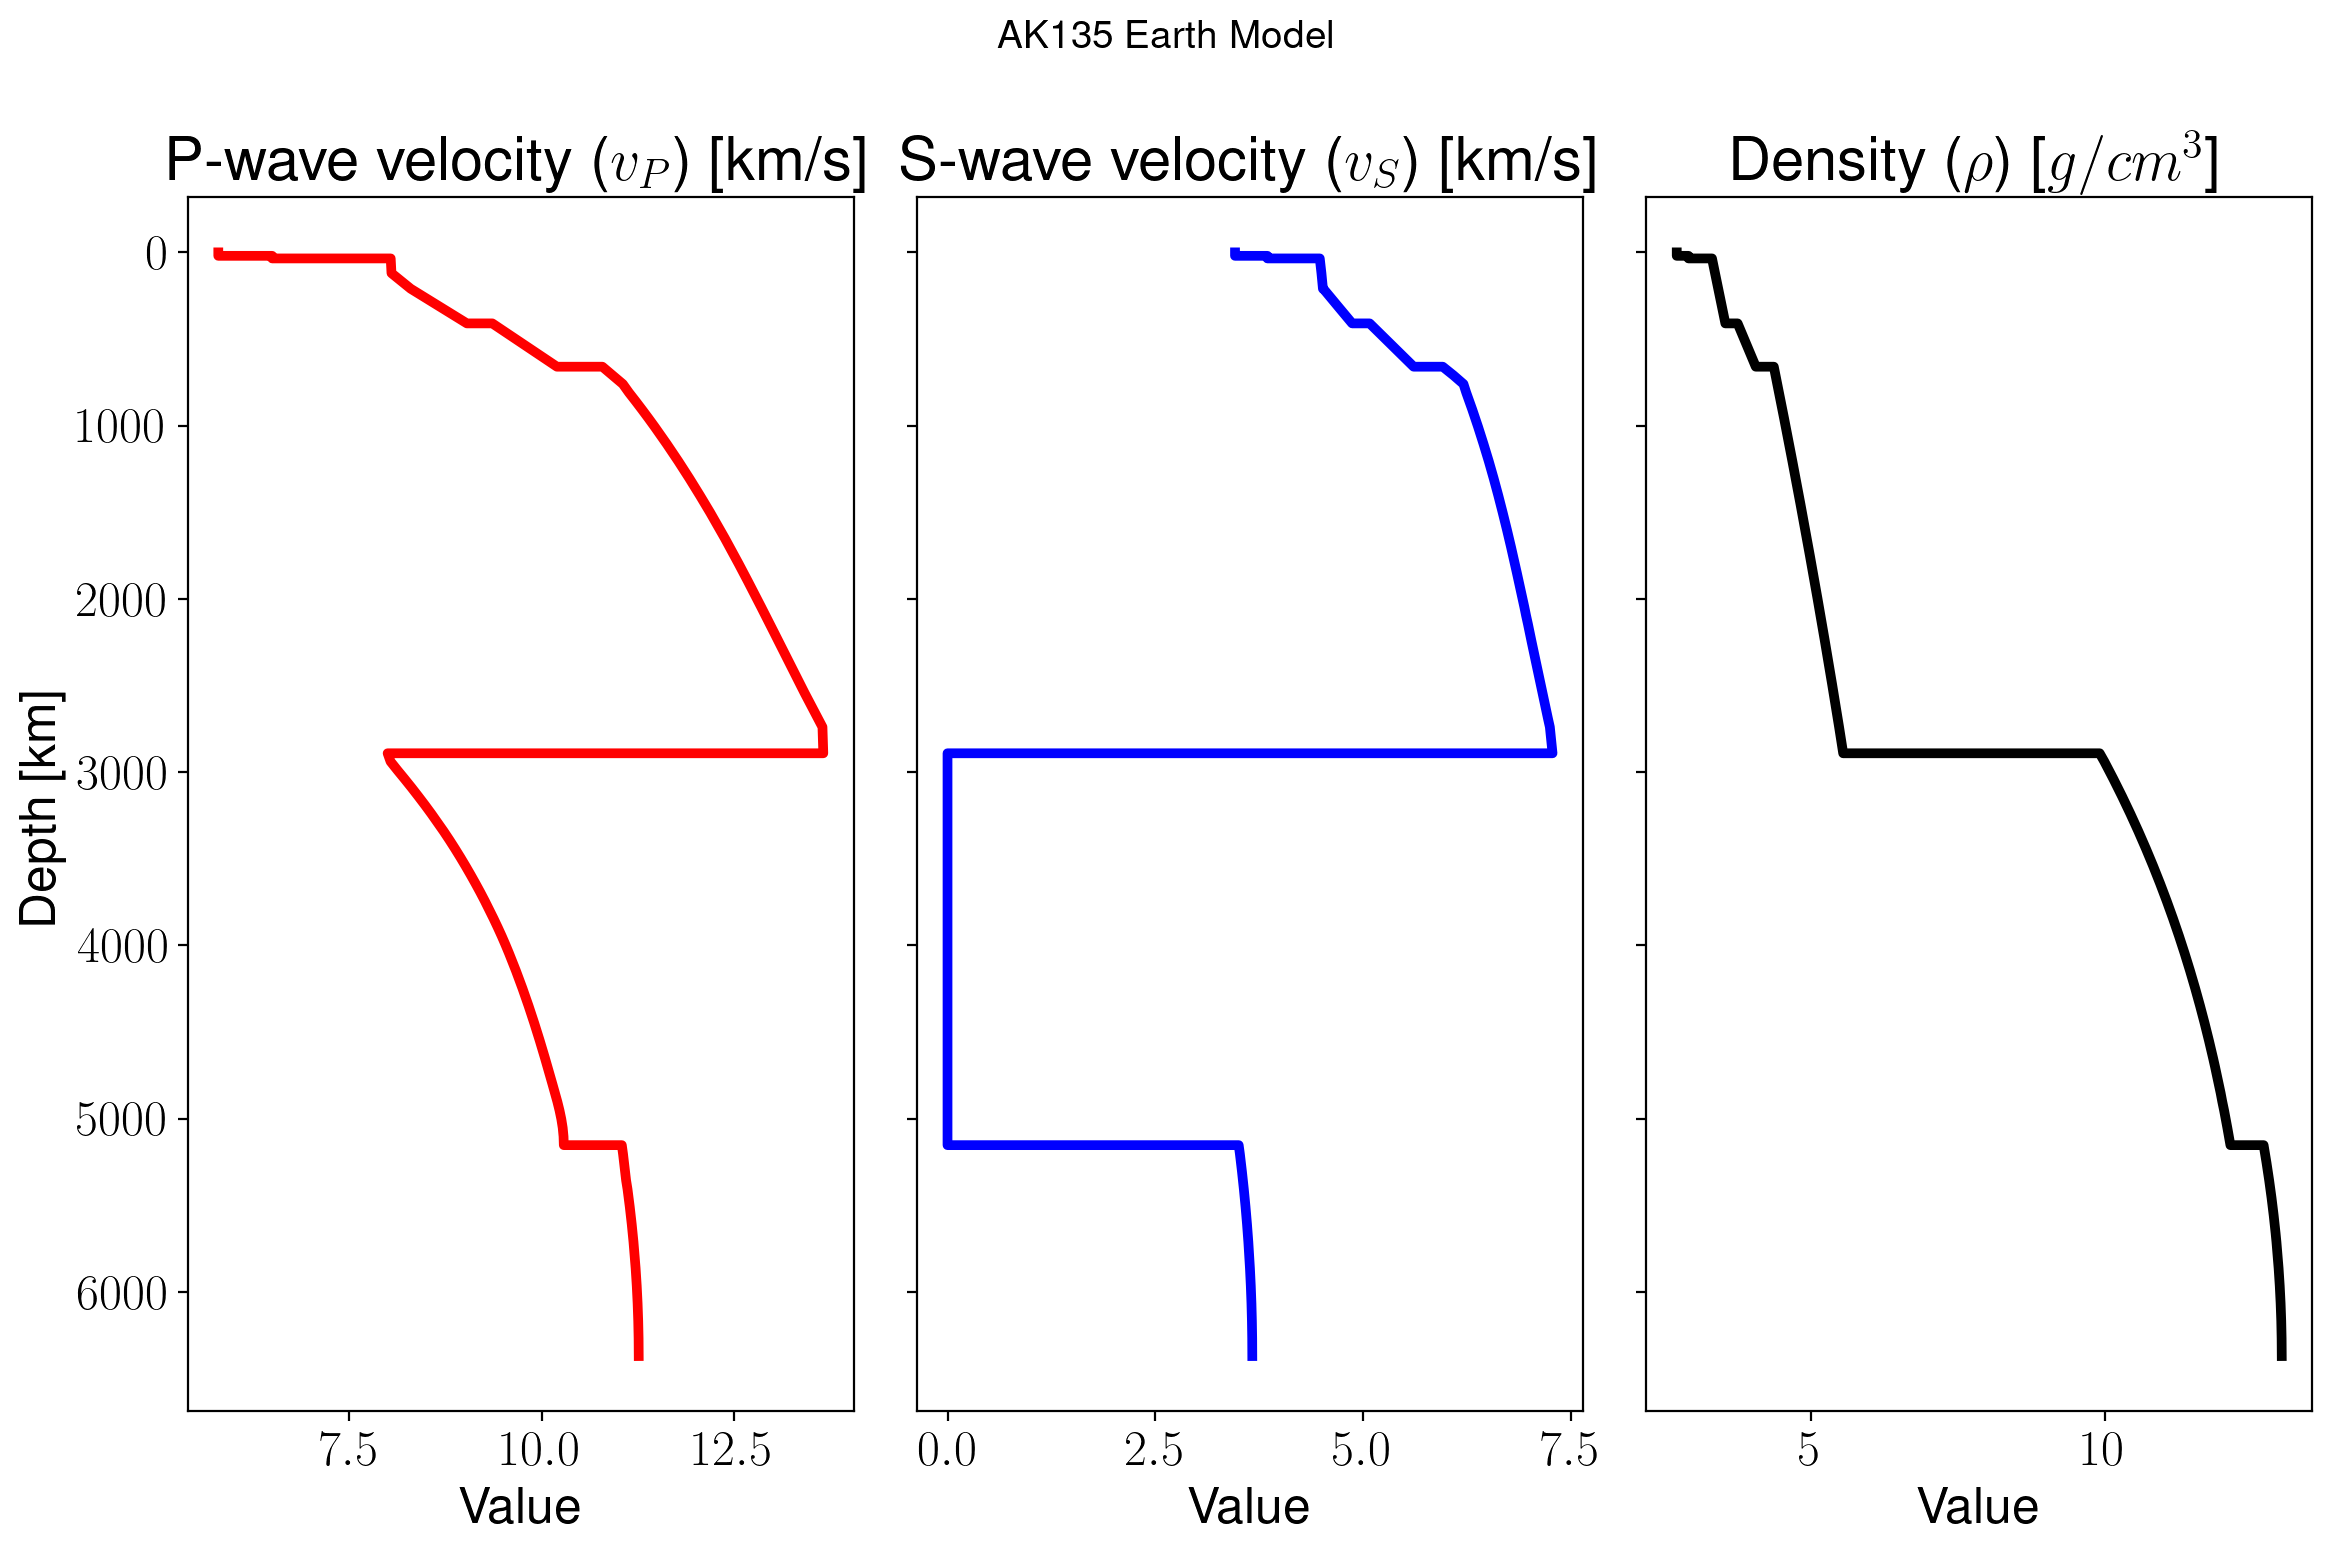

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "ak135.txt"
df = pd.read_csv(file_path, 
                 sep='\s+', 
                 skiprows=2, 
                 names=["Depth_km", "Vp", "Vs", "Rho"])
fig, ax = plt.subplots(1, 3, figsize=(12, 8), sharey=True)
ax[0].plot(df["Vp"], df["Depth_km"], color="red", lw=3.5, label="Vp")
ax[1].plot(df["Vs"], df["Depth_km"], color="blue", lw=3.5, label="Vs")
ax[2].plot(df["Rho"], df["Depth_km"], color="black", lw=3.5, label="Rho")
# Titles
ax[0].set_title("P-wave velocity ($v_P$) [km/s]")
ax[1].set_title("S-wave velocity ($v_S$) [km/s]")
ax[2].set_title(r"Density ($\rho$) [$g/cm^{3}$]")
for a in ax:
    a.invert_yaxis()
    a.grid(False)
    a.set_xlabel("Value")
ax[0].set_ylabel("Depth [km]")
plt.suptitle("AK135 Earth Model", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("ak135.pdf",dpi=300)

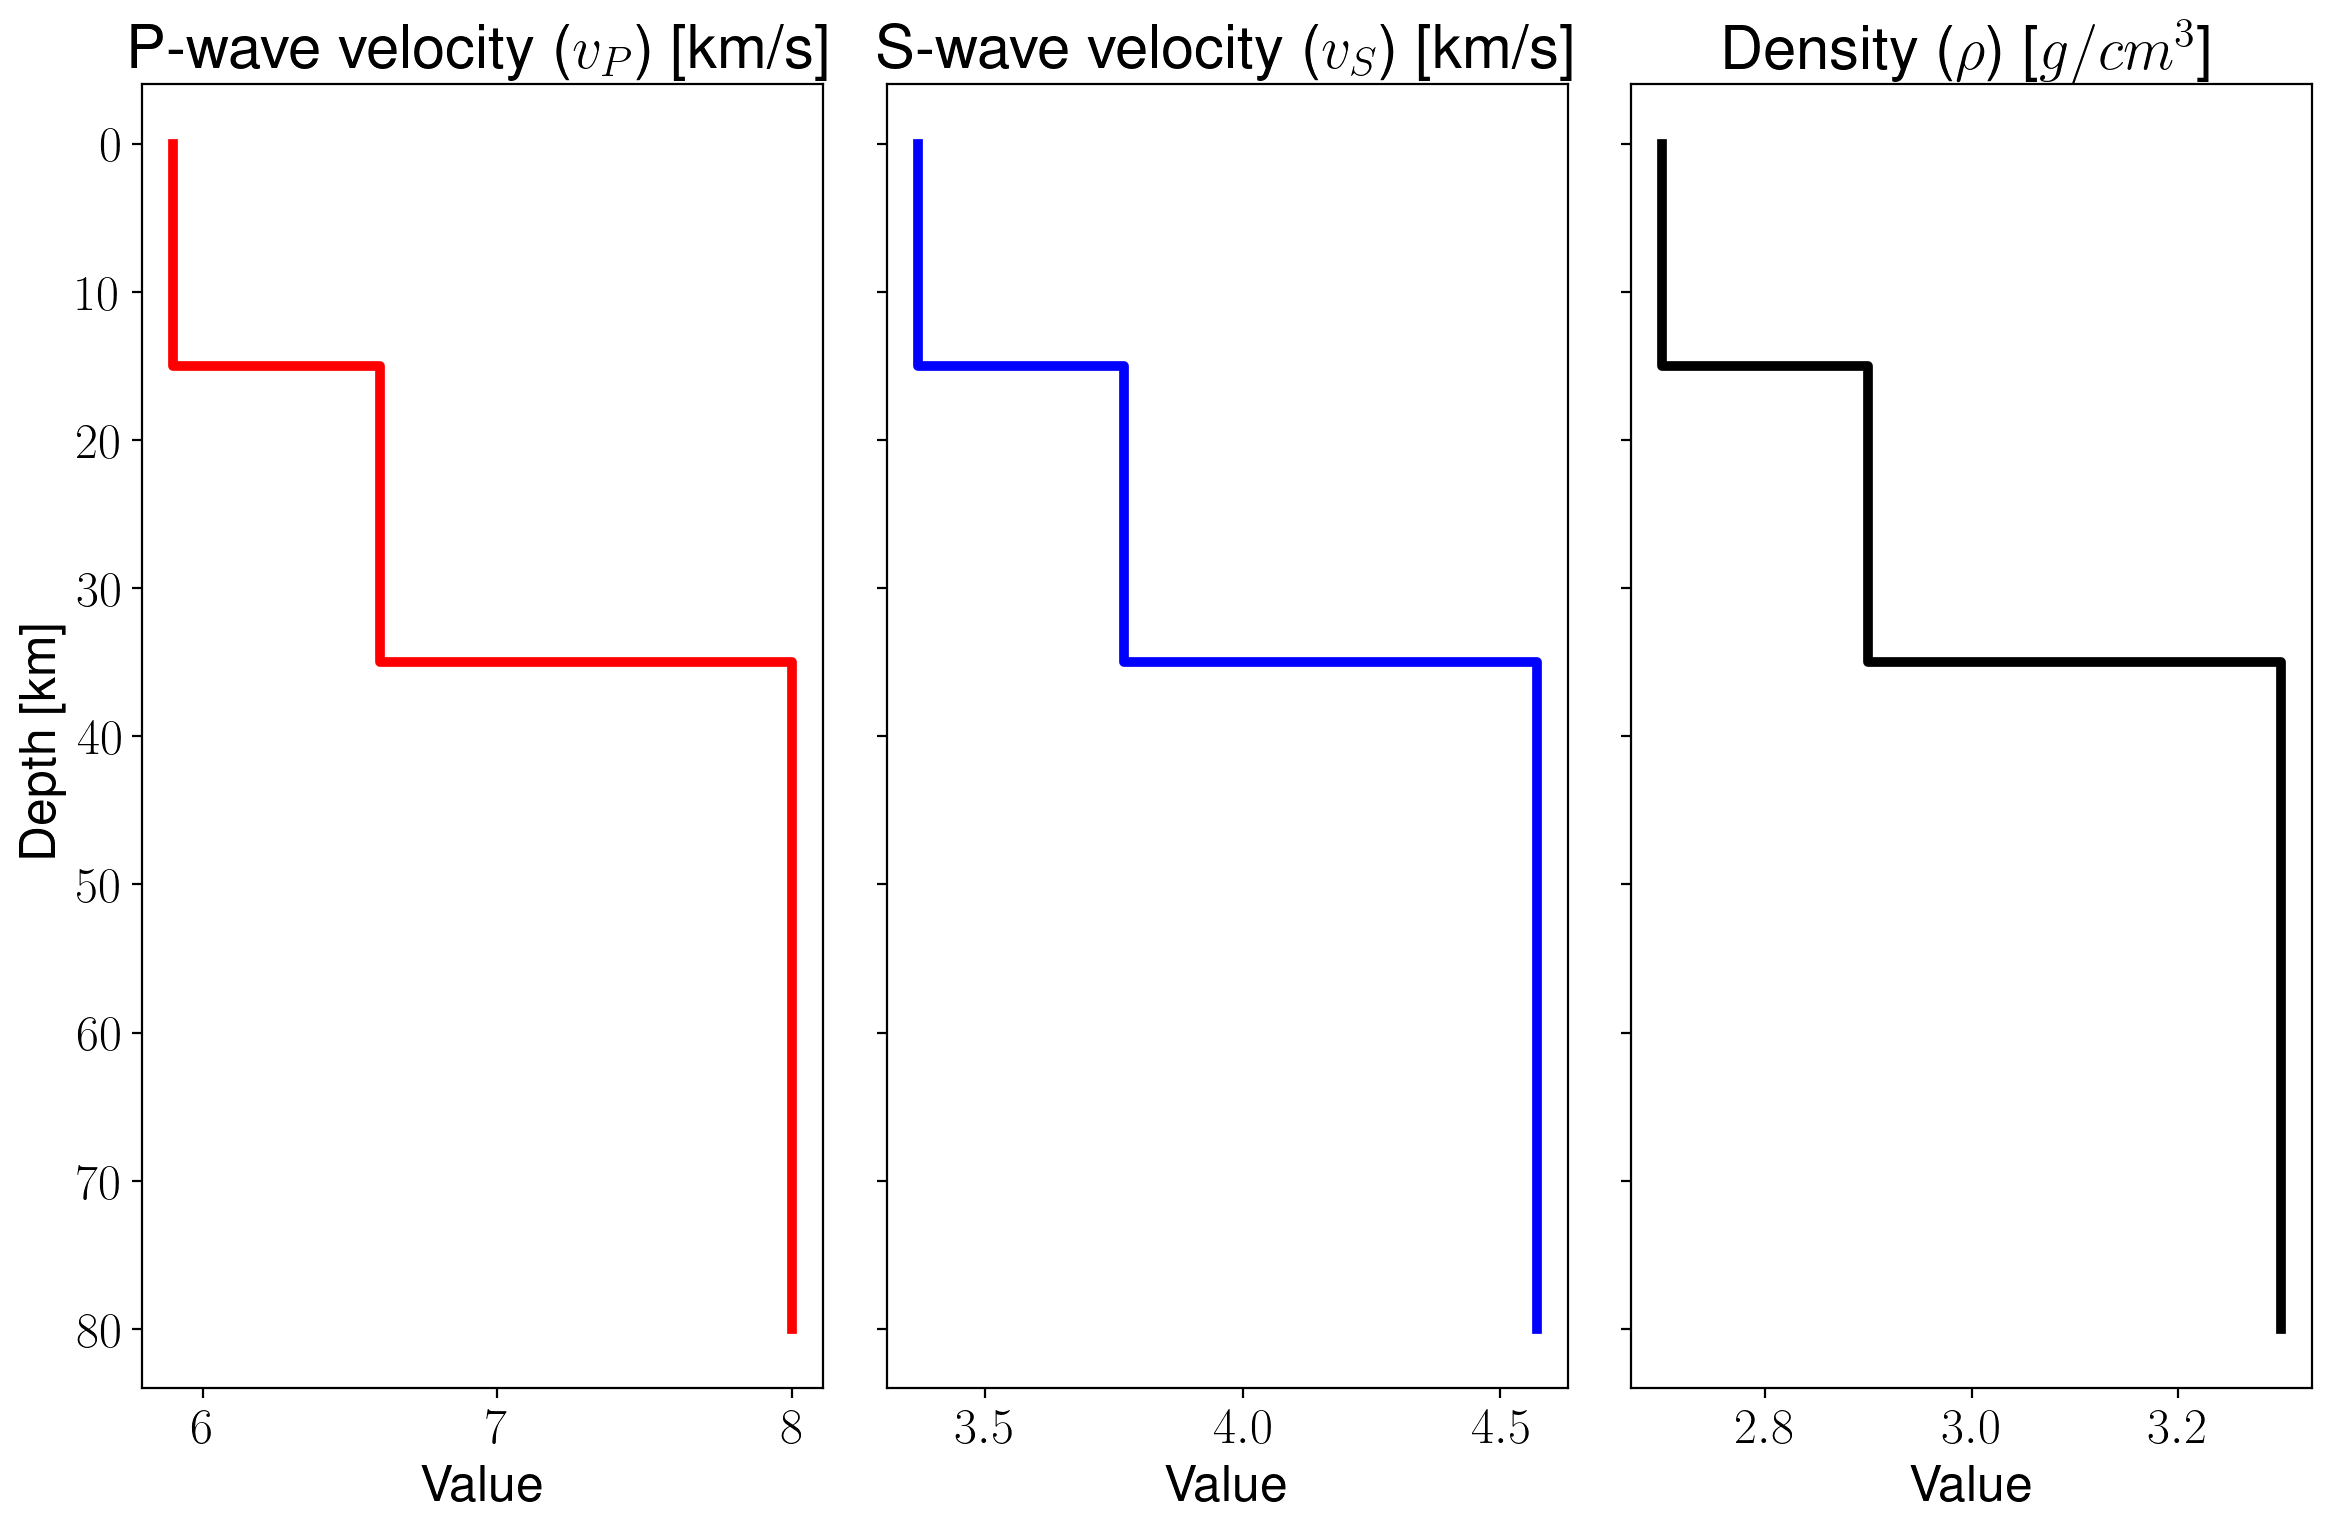

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "./sorg/modello.3strati.dat"
df = pd.read_csv(file_path, 
                 sep='\s+', 
                 names=["Depth_km", "Vp", "Vs", "Rho"])
fig, ax = plt.subplots(1, 3, figsize=(12, 8), sharey=True)
ax[0].plot(df["Vp"], df["Depth_km"], color="red", lw=3.5, label="Vp")
ax[1].plot(df["Vs"], df["Depth_km"], color="blue", lw=3.5, label="Vs")
ax[2].plot(df["Rho"], df["Depth_km"], color="black", lw=3.5, label="Rho")
# Titles
ax[0].set_title("P-wave velocity ($v_P$) [km/s]")
ax[1].set_title("S-wave velocity ($v_S$) [km/s]")
ax[2].set_title(r"Density ($\rho$) [$g/cm^{3}$]")
# Invert y-axis (depth increasing downward, Fortran/Geophysics style)
for a in ax:
    a.invert_yaxis()
    a.grid(False)
    a.set_xlabel("Value")
ax[0].set_ylabel("Depth [km]")
plt.tight_layout()
plt.savefig("trpl_layer.pdf",dpi=300)

## Scaling times (performance estimates)

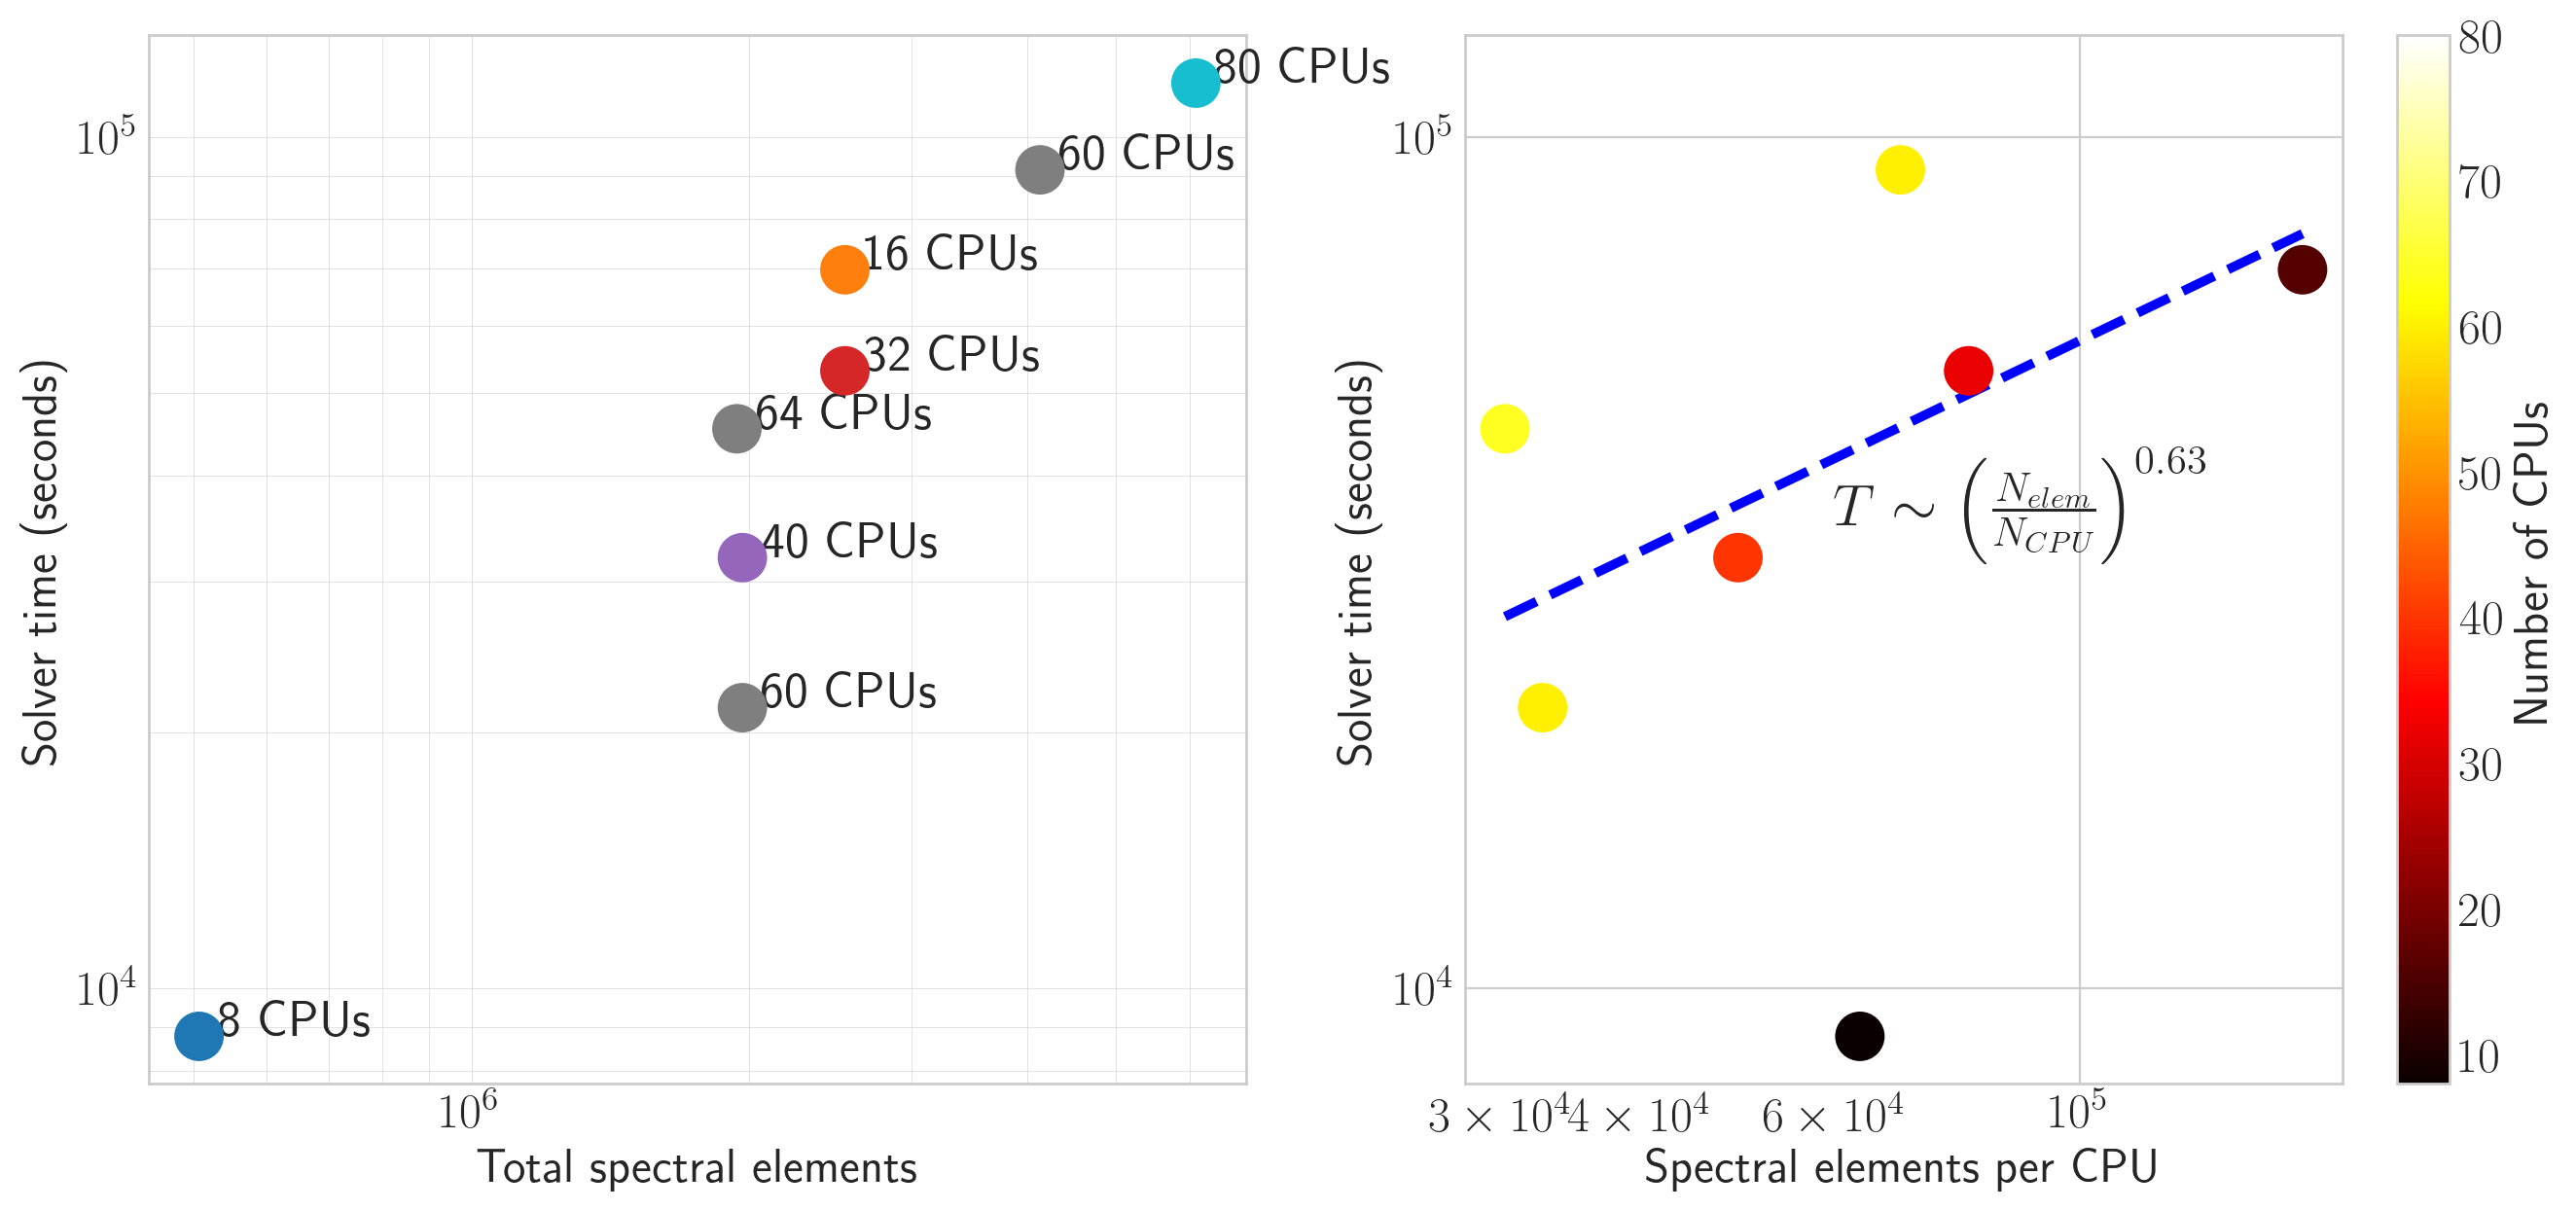

In [73]:
data_string = """
1.52   19.52  8
7.62   310.2  16
7.62   472.1  32
5.9    356.1  40
5.9    356.0  60
5.82   807.2  64
12.4   1524   60
18.3   2569   80
"""
data = np.loadtxt(io.StringIO(data_string))
dof_millions = data[:, 0]
cpu_hours = data[:, 1]
cpus = data[:, 2]
# Derived quantities
solver_time_s = (cpu_hours / cpus) * 3600
spectral_elements = (dof_millions * 1_000_000) / 3
elements_per_cpu = spectral_elements / cpus
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
# === Plot 1: Solver Time vs. Total Spectral Elements ===
ax1.scatter(spectral_elements, solver_time_s, c=cpus, cmap='tab10', s=300, zorder=9)
ax1.set_xlabel('Total spectral elements', fontsize=18, fontweight='bold')
ax1.set_ylabel('Solver time (seconds)', fontsize=18, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, which='both', linewidth=0.2)
for i, txt in enumerate(cpus):
    ax1.text(spectral_elements[i]*1.05, solver_time_s[i], f'{int(txt)} CPUs', fontsize=19)
# === Plot 2: Solver Time vs. Spectral Elements per CPU ===
scatter = ax2.scatter(elements_per_cpu, solver_time_s, c=cpus, cmap='hot', s=300, zorder=9)
# Fit a power law: log(y) = alpha*log(x) + beta
logx = np.log10(elements_per_cpu)
logy = np.log10(solver_time_s)
alpha, beta = np.polyfit(logx, logy, 1)
# Fitted line
x_fit = np.logspace(np.log10(elements_per_cpu.min()), np.log10(elements_per_cpu.max()), 200)
y_fit = 10**(alpha*np.log10(x_fit) + beta)
ax2.set_xlabel('Spectral elements per CPU', fontsize=18, fontweight='bold')
ax2.set_ylabel('Solver time (seconds)', fontsize=18, fontweight='bold')
ax2.plot(x_fit, y_fit, 'b--', linewidth=3.5)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.text(60000, 35000, r'$T \sim \left(\frac{N_{elem}}{N_{CPU}}\right)^{{0.63}}$', fontsize=22, weight="bold")
cbar = fig.colorbar(scatter, ax=ax2)
cbar.set_label('Number of CPUs', fontweight='bold')
plt.savefig("solvetime.pdf",dpi=300, transparent=True)
plt.show()


In [ ]:
layer_tops = [1.4, -20]
layer_bottoms = [-20, -80]
dz = [1.0, 4.2]  # mean spacing for each layer
fig, ax = plt.subplots(figsize=(5, 6))
for top, bottom, val in zip(layer_tops, layer_bottoms, dz):
    ax.barh(
        y=(top + bottom) / 2,    # center depth
        width=val,               # Δz value
        height=abs(bottom - top),# thickness (positive)
        color="#3CF527",
        edgecolor="black",
        align="center"
    )
ax.set_xlabel("Mean $\Delta z$ (km)")
ax.set_ylabel("Depth (km)")
ax.set_title("Vertical element spacing by layer")
ax.axvline(x=1.0, color="red", linestyle="--", linewidth=1.5)
ax.set_ylim(max(layer_tops), min(layer_bottoms))
ax.invert_yaxis()  # safer than flipping ylim manually
ax.tick_params(direction="in", right=True)
plt.tight_layout()
plt.savefig(f'vrtcl_spacing.pdf',dpi=300)